In [9]:
import os
import shutil
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

In [17]:
# Defining the paths to the directories containing positive and negative images
negative_dir = r'C:\Users\anand\OneDrive\Documents\BTP-Crack Detection\Detection_images\Negative'
positive_dir = r'C:\Users\anand\OneDrive\Documents\BTP-Crack Detection\Detection_images\Positive'

In [18]:
# Listing the files in the directories
positive_images = os.listdir(positive_dir)
negative_images = os.listdir(negative_dir)

# Getting the number of images in each directory
num_pos_images = len(positive_images)
num_neg_images = len(negative_images)

print("Number of positive images:", num_pos_images)
print("Number of negative images:", num_neg_images)

Number of positive images: 20000
Number of negative images: 20000


In [21]:
# Making train val split
train_positive_images = positive_images[:int(.8 * len(positive_images))]
val_positive_images = positive_images[int(.8 * len(positive_images)):]

train_negative_images = negative_images[:int(.8 * len(negative_images))]
val_negative_images = negative_images[int(.8 * len(negative_images)):]

train_dir = './train_data/'
val_dir = './val_data/'

os.makedirs(train_dir + 'Positive/', exist_ok=True)
os.makedirs(train_dir + 'Negative/', exist_ok=True)
os.makedirs(val_dir + 'Positive/', exist_ok=True)
os.makedirs(val_dir + 'Negative/', exist_ok=True)

In [22]:
for image in train_positive_images:
    src = os.path.join(positive_dir, image)
    dst = os.path.join(train_dir, 'Positive', image)
    shutil.copy(src, dst)

for image in train_negative_images:
    src = os.path.join(negative_dir, image)
    dst = os.path.join(train_dir, 'Negative', image)
    shutil.copy(src, dst)

for image in val_positive_images:
    src = os.path.join(positive_dir, image)
    dst = os.path.join(val_dir, 'Positive', image)
    shutil.copy(src, dst)

for image in val_negative_images:
    src = os.path.join(negative_dir, image)
    dst = os.path.join(val_dir, 'Negative', image)
    shutil.copy(src, dst)

In [23]:
def viewing_random_image(target_dir, target_class):
    target_folder = target_dir + target_class + '/'
    random_image = random.choice(os.listdir(target_folder))
    
    img = mpimg.imread(target_folder + random_image)
    print(img.shape)
    plt.title(target_class)
    plt.imshow(img)
    plt.axis('off')

(227, 227, 3)


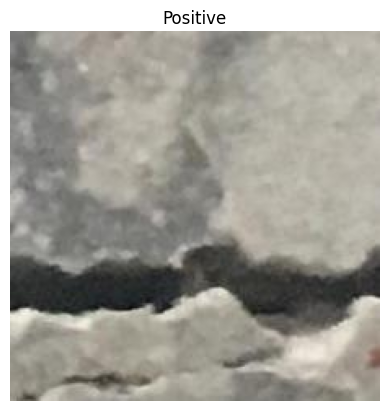

In [24]:
viewing_random_image(train_dir, 'Positive')

In [25]:
train_data_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1/255.)
val_data_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1/255.)

train_dataset = train_data_gen.flow_from_directory(train_dir,
                                                  target_size = (227,227),
                                                  class_mode = 'binary')

val_dataset = val_data_gen.flow_from_directory(val_dir,
                                              target_size = (227,227),
                                              class_mode = 'binary')

Found 32000 images belonging to 2 classes.
Found 8000 images belonging to 2 classes.


In [26]:
input_shape = (227,227,3)

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape = input_shape),
    
    tf.keras.layers.Conv2D(10, 3, activation = 'relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(10, 3, activation = 'relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(10, 3, activation = 'relu'),
    tf.keras.layers.MaxPool2D(),
    
    tf.keras.layers.GlobalAveragePooling2D(),
    
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

model.compile(loss = 'binary_crossentropy',
             metrics = ['accuracy'],
             optimizer = 'adam')

In [27]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 225, 225, 10)   │           280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 10)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 110, 110, 10)   │           910 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 55, 55, 10)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 53, 53, 10)     │           910 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 10)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 10)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,111 (8.25 KB)

 Trainable params: 2,111 (8.25 KB)

 Non-trainable params: 0 (0.00 B)

In [28]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', mode = 'max', patience = 15)

history= model.fit(train_dataset,
                  epochs = 100,
                  validation_data = val_dataset,
                  callbacks = [early_stopping])

Epoch 1/100


c:\Users\anand\OneDrive\Documents\BTP-Crack Detection\btpenv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 313s 311ms/step - accuracy: 0.7531 - loss: 0.4907 - val_accuracy: 0.9499 - val_loss: 0.1521
Epoch 2/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 131s 130ms/step - accuracy: 0.9655 - loss: 0.1217 - val_accuracy: 0.9714 - val_loss: 0.0909
Epoch 3/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 126s 126ms/step - accuracy: 0.9747 - loss: 0.0824 - val_accuracy: 0.9840 - val_loss: 0.0569
Epoch 4/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 124s 124ms/step - accuracy: 0.9786 - loss: 0.0667 - val_accuracy: 0.9787 - val_loss: 0.0613
Epoch 5/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 125s 125ms/step - accuracy: 0.9811 - loss: 0.0601 - val_accuracy: 0.9739 - val_loss: 0.0730
Epoch 6/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 132s 132ms/step - accuracy: 0.9820 - loss: 0.0590 - val_accuracy: 0.9825 - val_loss: 0.0542
Epoch 7/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 130s 130ms/step - accuracy: 0.9821 - loss: 0.0605 - val_accuracy: 0.9760 - val_loss: 0.0718
Epoch 8/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 125s 125ms/step - accura

In [30]:
# Save the model
model.save('crack_detection_model.h5')

In [39]:
# Load the saved model
model = tf.keras.models.load_model('crack_detection_model.h5')
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
def predict_image(img_path, model):
    img = load_img(img_path, target_size=(227, 227))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0
    prediction = model.predict(img_array)
    return prediction[0][0]

path = r'C:\Users\anand\OneDrive\Documents\BTP-Crack Detection\00015.jpg'
prediction = predict_image(path, model)
prediction_threshold = 0.5

if prediction >= prediction_threshold:
    print("Crack detected.")
else:
    print("No crack detected.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Crack detected.
